In [1]:
from scipy.stats import skewnorm, lognorm, gamma, kstest, skew
import tools
import pickle
import numpy as np
import tqdm
from scipy.special import erf
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import math

In [2]:
all_df = pickle.load(open('../pickles/NP_df.p','rb'))

all_statistics = tools.get_statistics(all_df)

flat = np.concatenate(all_df['norm']).ravel()

flat = flat[~np.isnan(flat)]

sn_a, sn_loc, sn_scale = skewnorm.fit(flat)

ln_a, ln_loc, ln_scale = lognorm.fit(flat)

ga_a, ga_loc, ga_scale = gamma.fit(flat)

/home/robbie/Dropbox/sub_km/notebooks/tools.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  CV = np.linalg.lstsq(np.array(df['mean'])[:, np.newaxis], df['std'])[0][0]


In [3]:
skew(flat),lognorm.fit(flat),skewnorm.fit(flat),gamma.fit(flat)

(0.5671627823838165,
 (0.17010186101693794, -5.816583784086433, 5.732914591906359),
 (2.542562886886376, -1.114525560819975, 1.4973819434202296),
 (26.154352745683536, -5.063377613875462, 0.19359597647311097))

In [4]:
bw = 0.1

bin_edges = np.arange(-2.5,3,bw)

bin_centres = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2

sn_fit = skewnorm.pdf(bin_centres, sn_a, sn_loc, sn_scale)

ln_fit = lognorm.pdf(bin_centres, ln_a, ln_loc, ln_scale)

ga_fit = gamma.pdf(bin_centres, ga_a, ga_loc, ga_scale)

In [5]:
snks = kstest(flat, 'skewnorm', args=[sn_a,sn_loc,sn_scale])

lnks = kstest(flat, 'lognorm', args=[ln_a,ln_loc,ln_scale])

gaks = kstest(flat, 'gamma', args=[ga_a,ga_loc,ga_scale])


ks_stats = []
ks_probs = []
for i in (snks,lnks,gaks):
    
    print(i)
    ks_stats.append(i[0])
    ks_probs.append(i[1])

KstestResult(statistic=0.013389932424065165, pvalue=1.185674642746816e-05)
KstestResult(statistic=0.016727377987930836, pvalue=1.3949534796974117e-08)
KstestResult(statistic=0.02206138371767885, pvalue=1.3023085078948448e-14)


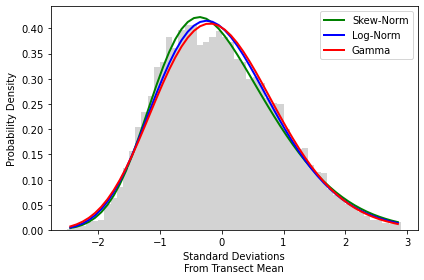

In [6]:
p, x = np.histogram(flat,
                    bins=bin_edges,
                    density=True,
                   )

plt.bar(bin_centres, p, color='lightgrey',width=bw)


plt.plot(bin_centres, sn_fit, lw=2, color='g', label='Skew-Norm')

plt.plot(bin_centres, ln_fit, lw=2, color='b', label='Log-Norm')

plt.plot(bin_centres, ga_fit, lw=2, color='r', label='Gamma')

plt.legend()

plt.ylabel('Probability Density')

plt.xlabel('Standard Deviations\nFrom Transect Mean')

plt.tight_layout()

# plt.savefig('../submission/skew_log_comparison.png', dpi=400)

In [7]:
RMSEs = []

for d in [sn_fit, ln_fit, ga_fit]:
    
    MSE = np.square(np.subtract(p,d)).mean() 
 
    RMSE = math.sqrt(MSE)
    
    RMSEs.append(RMSE)
    


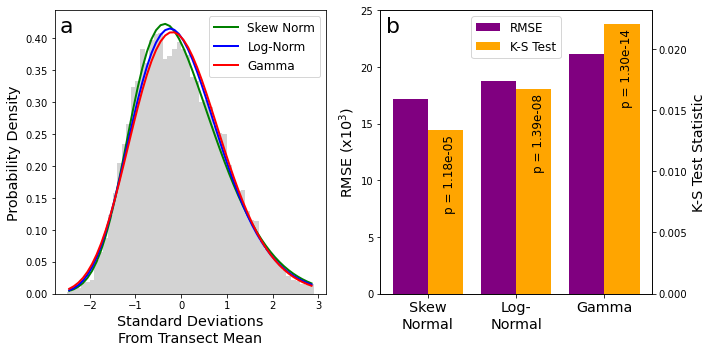

In [18]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.bar(bin_centres, p, color='lightgrey',width=bw)

ax1.plot(bin_centres, sn_fit, lw=2, color='g', label='Skew Norm')

ax1.plot(bin_centres, ln_fit, lw=2, color='b', label='Log-Norm')

ax1.plot(bin_centres, ga_fit, lw=2, color='r', label='Gamma')

ax1.legend(fontsize='large')

ax1.set_ylabel('Probability Density', fontsize='x-large')

ax1.set_xlabel('Standard Deviations\nFrom Transect Mean', fontsize='x-large')

########

ax2b = ax2.twinx()

ax2.bar(np.arange(3)-0.2,np.array(RMSEs)*1000,width=0.4, label='RMSE',color='purple')
ax2.set_ylim(0,25)
ax2.set_ylabel('RMSE (x10$^3$)', fontsize='x-large')
ax2.bar(x=[2],height=[0],label='K-S Test',color='orange')

ax2b.bar(np.arange(3)+0.2,ks_stats,width=0.4, label='K-S Test', color='orange')
ax2b.set_ylabel('K-S Test Statistic', fontsize='x-large')

ax2.set_xticks(np.arange(3))
ax2.set_xticklabels(['Skew\nNormal','Log-\nNormal','Gamma'], fontsize='x-large')

for i, h, x in zip(ks_probs,ks_stats, [0,1,2]):
    
    last = str(i)[-4:]
    first = str(i)[:4]
    ax2b.annotate(f'p = {first}{last} ',rotation=90,xy=(x+0.25,h),
                  xycoords='data',va='top',ha='center', fontsize='large')

ax2.legend(loc='upper center',fontsize='large')

fontsize=22

ax1.annotate('a', fontsize=fontsize, xy=(0.02,0.98),
             va='top',xycoords= 'axes fraction')
ax2.annotate('b', fontsize=fontsize, xy=(0.02,0.98),
             va='top',xycoords= 'axes fraction')

plt.tight_layout()

plt.savefig('../figures/fig_4.png', bbox_inches='tight',dpi=500)
plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/sub-km-snow-depth-dist/figs/fig4.png', dpi=400)

In [27]:
frac_sigs = []

for j in tqdm.trange(10_000):

    rs = []; ps = []

    for i in range(100):
        x = np.random.normal(size=100)
        r, p = pearsonr(np.arange(100),x)
        rs.append(r); ps.append(p)

    rs = np.array(rs); ps = np.array(ps)

    n_sig = len(rs[ps<0.05])

    frac_sigs.append( n_sig/100 )

frac_sigs = np.array(frac_sigs)

100%|██████████| 10000/10000 [01:08<00:00, 145.28it/s]


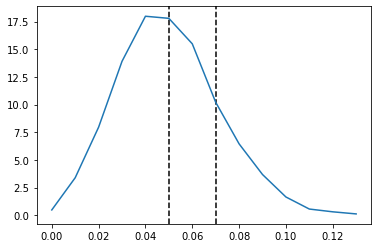

In [35]:
plt.axvline(0.05,color='k',ls='--')
plt.axvline(0.07,color='k',ls='--')
h, be = np.histogram(frac_sigs,bins=np.arange(0,0.15,0.01), density=True)
plt.plot(be[:-1],h)

In [12]:
frac_sigs[frac_sigs>0.07]

TypeError: '>' not supported between instances of 'list' and 'float'